In [1]:
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D

from correlation_ansatzs import ising_four_sigma_correlation,loglog
from scipy.optimize import curve_fit,minimize

data=pd.read_pickle('data/hotrg_gilt_X24_4pt_correlation_10.pkl')
def process_data(data):
    lattice_size=get_lattice_size(20,spacial_dim=2)
    for i in range(4):
        for j in range(i+1,4):
            data['dist{}{}'.format(i,j)]=data.apply(lambda row:get_dist_2D(row['x{}'.format(i)]-row['x{}'.format(j)],row['y{}'.format(i)]-row['y{}'.format(j)]),axis=1)
    dists=[data['dist{}{}'.format(i,j)].to_numpy() for i in range(4) for j in range(i+1,4)]
    data['expected']=ising_four_sigma_correlation(dists,Anorm=1,deltaSigma=0.125,deltaEpsilon=1,CdeltadeltaEpsilon=.5)
    return data
data=process_data(data)

def fitWithHuberLoss(ansatz,x,y,p0=None,epsilon=1,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6)
    p=res.x
    return p

# fit the data 
dists=[data['dist{}{}'.format(i,j)].to_numpy() for i in range(4) for j in range(i+1,4)]
corr=data['correlation'].to_numpy()
logDists=[np.log(dists[i]) for i in range(6)]
logCorr=np.log(corr)
print('start fitting')
# loglog scale
p,cov=curve_fit(loglog(ising_four_sigma_correlation),logDists,logCorr,
                p0=ising_four_sigma_correlation.p0,bounds=ising_four_sigma_correlation.bounds)
# linear scale
# p,cov=curve_fit(ising_four_sigma_correlation,dists,corr,
#                p0=ising_four_sigma_correlation.p0,bounds=ising_four_sigma_correlation.bounds)
print('fitted parameters:',p)
print('covariance matrix:',cov)
print('fitted equation:',ising_four_sigma_correlation.eq.format(*p))

print('refining fitting with Huber loss')
p=fitWithHuberLoss(loglog(ising_four_sigma_correlation),logDists,logCorr,p0=p,epsilon=.1)
cov=None
print('fitted parameters:',p)
print('fitted equation:',ising_four_sigma_correlation.eq.format(*p))





[GILT] Warning! float32 is not precise enough, leads to bad RG behavior
[GILT] Warning! float32 is not precise enough, leads to bad RG behavior
start fitting
fitted parameters: [0.61567983 0.17613768 1.50171748 0.37264522]
covariance matrix: [[ 5.63603655e-04  5.38283820e-05  1.93313855e-04 -1.40416637e-05]
 [ 5.38283820e-05  6.11459699e-06 -2.15486374e-05  1.56242166e-05]
 [ 1.93313855e-04 -2.15486374e-05  5.95674426e-03 -1.46453902e-03]
 [-1.40416637e-05  1.56242166e-05 -1.46453902e-03  4.65702261e-04]]
fitted equation: A=6.16e-01,Δσ=0.1761,Δε=1.5017,C(σσε)=0.3726
refining fitting with Huber loss
fitted parameters: [0.2062048  0.11010378 1.07591539 0.43871535]
fitted equation: A=2.06e-01,Δσ=0.1101,Δε=1.0759,C(σσε)=0.4387


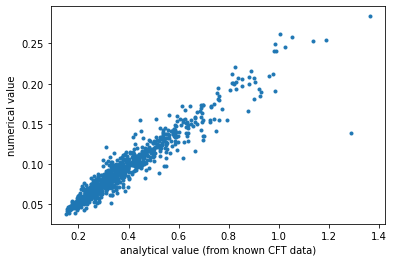

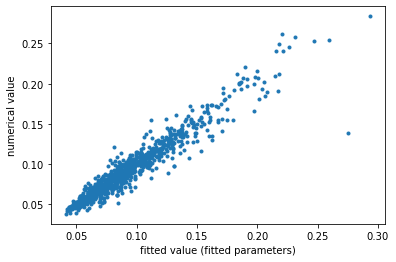

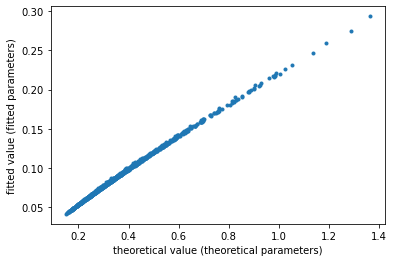

In [2]:
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.figure(figsize=(6,4))
plt.plot(data['expected'],data['correlation'],'.')
plt.xlabel('analytical value (from known CFT data)')
plt.ylabel('numerical value')
plt.show()


fitted_expected=ising_four_sigma_correlation(dists,*p)
plt.figure(figsize=(6,4))
plt.plot(fitted_expected,data['correlation'],'.')
plt.xlabel('fitted value (fitted parameters)')
plt.ylabel('numerical value')
plt.show()


plt.figure(figsize=(6,4))
plt.plot(data['expected'],fitted_expected,'.')
plt.xlabel('theoretical value (theoretical parameters)')
plt.ylabel('fitted value (fitted parameters)')
plt.show()